# Assignment 2: CoinPilot user segmentation, modelling, and lightweight deployment

## Business issues to address
1. User segmentation challenge  
2. Premium conversion prediction  
3. Portfolio and engagement patterns  
4. Operationalisation via lightweight deployment  

---

## 0) Setup cell to install packages

In [ ]:
# # Install required libraries
# # Run this cell once at the start
# !pip install numpy pandas scikit-learn xgboost matplotlib fastapi "pydantic<2" uvicorn streamlit joblib requests

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1) Data preparation and sanity checks
### Your tasks in this section:
- Load the dataset into a Pandas DataFrame.
- Display descriptive statistics and feature distributions.
- Calculate and display the premium conversion rate overall and by `country`.
- Produce at least one simple chart (e.g., bar chart of conversion rate by `country`).


In [3]:
# Load dataset here
coinpilot_data = pd.read_csv("coinpilot_data.csv")

Dataset Basic Information:
Data shape: (100000, 16)
Column names: ['age', 'tenure_months', 'income_monthly', 'savings_rate', 'risk_score', 'app_opens_7d', 'sessions_7d', 'avg_session_min', 'alerts_opt_in', 'auto_invest', 'country', 'equity_pct', 'bond_pct', 'cash_pct', 'crypto_pct', 'converted_premium']

Data types:
age                    int64
tenure_months          int64
income_monthly       float64
savings_rate         float64
risk_score           float64
app_opens_7d           int64
sessions_7d            int64
avg_session_min      float64
alerts_opt_in          int64
auto_invest            int64
country               object
equity_pct           float64
bond_pct             float64
cash_pct             float64
crypto_pct           float64
converted_premium      int64
dtype: object

Descriptive Statistics:
                 age  tenure_months  income_monthly   savings_rate  \
count  100000.000000  100000.000000   100000.000000  100000.000000   
mean       32.996900      24.555190    

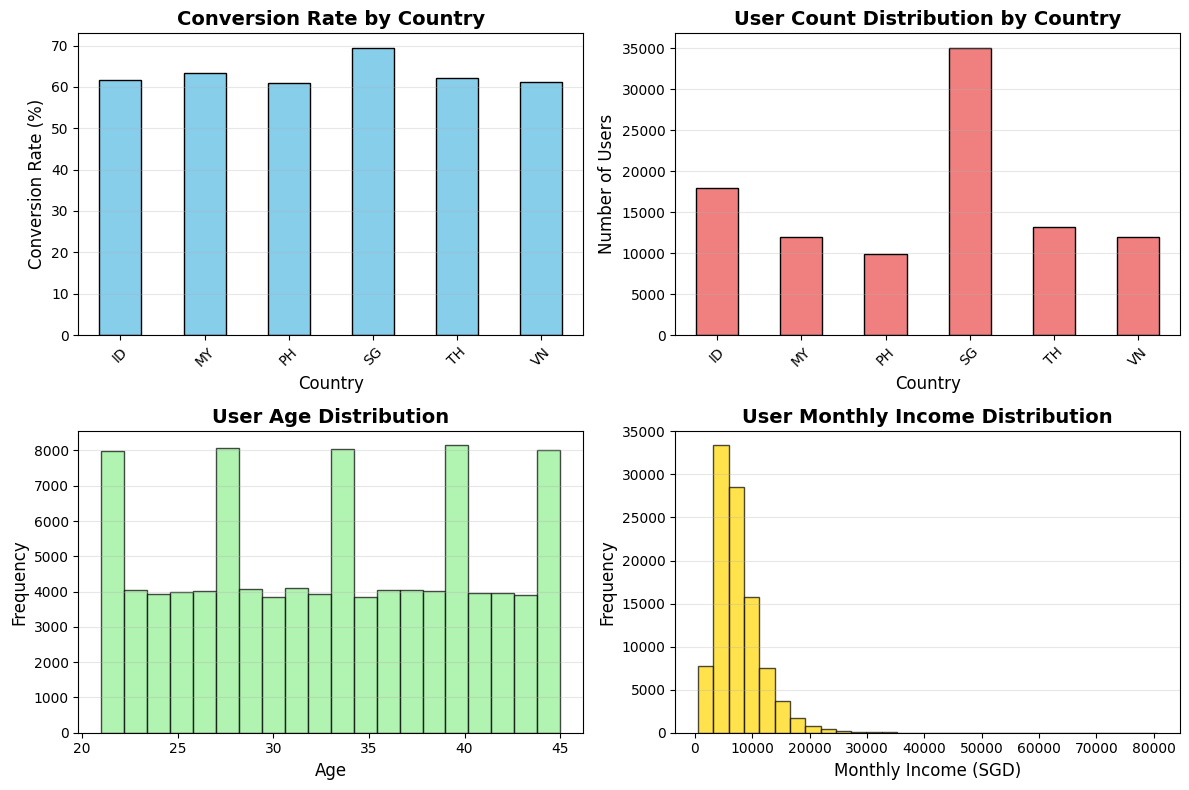


Portfolio Allocation Analysis:
          equity_pct       bond_pct       cash_pct     crypto_pct
count  100000.000000  100000.000000  100000.000000  100000.000000
mean       35.778519      19.511612      21.367532      23.342336
std        18.834470      15.750504      16.160443      16.575822
min         0.097401       0.000156       0.000189       0.000657
25%        21.026558       6.994775       8.502074      10.087341
50%        33.985635      15.680385      17.775533      20.085634
75%        48.860576      28.336360      30.877812      33.517209
max        97.600940      93.524190      94.576326      93.770060

Portfolio Percentage Total Statistics:
Mean: 100.00%
Standard deviation: 0.00%
Minimum: 100.00%
Maximum: 100.00%


In [4]:
# Display descriptive statistics
print("Dataset Basic Information:")
print(f"Data shape: {coinpilot_data.shape}")
print(f"Column names: {list(coinpilot_data.columns)}")
print("\nData types:")
print(coinpilot_data.dtypes)
print("\nDescriptive Statistics:")
print(coinpilot_data.describe())

# Check for missing values
print("\nMissing Values Check:")
print(coinpilot_data.isnull().sum())

# Display feature distributions for key variables
print("\nKey Feature Distributions:")
print(f"Age range: {coinpilot_data['age'].min()} - {coinpilot_data['age'].max()}")
print(f"Tenure range: {coinpilot_data['tenure_months'].min()} - {coinpilot_data['tenure_months'].max()}")
print(f"Monthly income range: {coinpilot_data['income_monthly'].min():.2f} - {coinpilot_data['income_monthly'].max():.2f}")
print(f"Risk score range: {coinpilot_data['risk_score'].min():.2f} - {coinpilot_data['risk_score'].max():.2f}")

# Conversion rate overall and by country
overall_conversion_rate = coinpilot_data['converted_premium'].mean()
print(f"\nOverall Premium Conversion Rate: {overall_conversion_rate:.4f} ({overall_conversion_rate*100:.2f}%)")

print("\nConversion Rate by Country:")
conversion_by_country = coinpilot_data.groupby('country')['converted_premium'].agg(['count', 'sum', 'mean']).round(4)
conversion_by_country.columns = ['Total Users', 'Premium Users', 'Conversion Rate']
conversion_by_country['Conversion Rate %'] = (conversion_by_country['Conversion Rate'] * 100).round(2)
print(conversion_by_country)

# Simple visualisation (e.g. bar chart)
plt.figure(figsize=(12, 8))

# Subplot 1: Conversion rate by country bar chart
plt.subplot(2, 2, 1)
conversion_by_country['Conversion Rate %'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Conversion Rate by Country', fontsize=14, fontweight='bold')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Conversion Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Subplot 2: User count distribution by country
plt.subplot(2, 2, 2)
conversion_by_country['Total Users'].plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('User Count Distribution by Country', fontsize=14, fontweight='bold')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Subplot 3: Age distribution histogram
plt.subplot(2, 2, 3)
plt.hist(coinpilot_data['age'], bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title('User Age Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Subplot 4: Monthly income distribution histogram
plt.subplot(2, 2, 4)
plt.hist(coinpilot_data['income_monthly'], bins=30, color='gold', edgecolor='black', alpha=0.7)
plt.title('User Monthly Income Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Monthly Income (SGD)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Portfolio allocation analysis
print("\nPortfolio Allocation Analysis:")
portfolio_cols = ['equity_pct', 'bond_pct', 'cash_pct', 'crypto_pct']
portfolio_stats = coinpilot_data[portfolio_cols].describe()
print(portfolio_stats)

# Check if portfolio percentages are reasonable (should be close to 100%)
coinpilot_data['portfolio_total'] = coinpilot_data[portfolio_cols].sum(axis=1)
print(f"\nPortfolio Percentage Total Statistics:")
print(f"Mean: {coinpilot_data['portfolio_total'].mean():.2f}%")
print(f"Standard deviation: {coinpilot_data['portfolio_total'].std():.2f}%")
print(f"Minimum: {coinpilot_data['portfolio_total'].min():.2f}%")
print(f"Maximum: {coinpilot_data['portfolio_total'].max():.2f}%")

## 2) Unsupervised user segmentation

### Your tasks in this section:
- Carry out PCA and produce the scree plot.
- Run t-SNE and produce a labelled scatterplot.
- Apply k-means with your chosen `k` and profile the clusters.
- Provide short markdown commentary on patterns you observe.


***2.1PCA with scree plot***


Scaled feature matrix shape: (100000, 14)
Continuous features standardized; binary kept as 0/1 and concatenated.


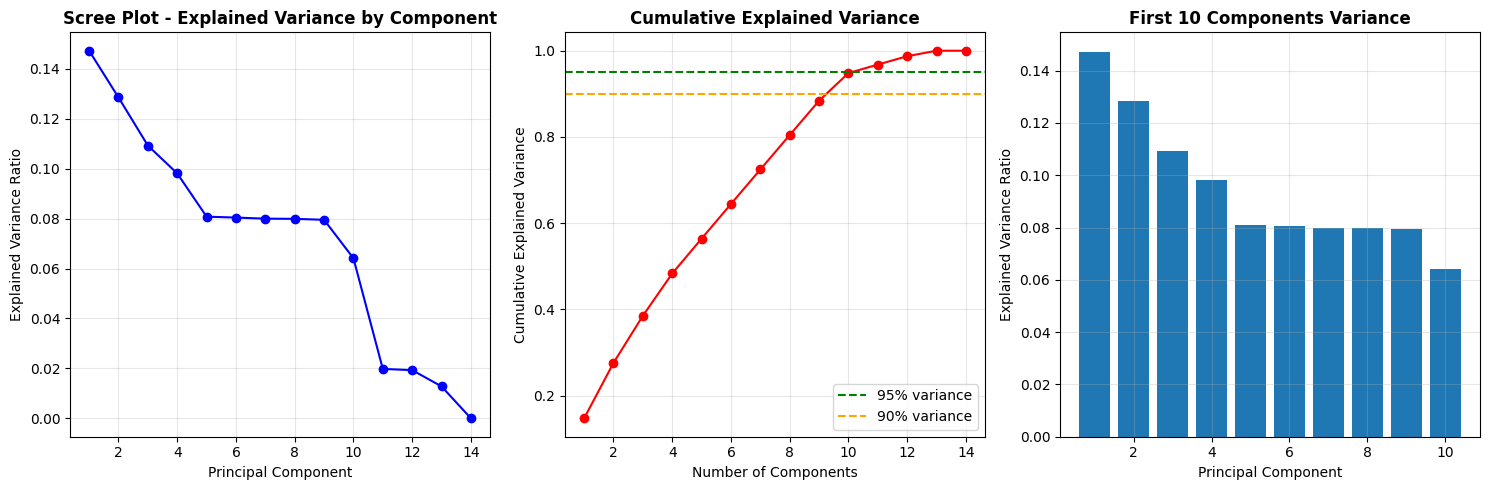

Total number of components: 14
Variance explained by first 5 components: [0.14728043 0.27584556 0.38512661 0.48325597 0.56405046]
Variance explained by first 10 components: [0.14728043 0.27584556 0.38512661 0.48325597 0.56405046 0.64448461
 0.72447862 0.80440424 0.88394171 0.94808369]
Number of components for 95% variance: 11
Number of components for 90% variance: 10

Selected number of components: 11 (explains 0.968 of variance)


In [5]:
# Select numeric features (excluding target variable)
numeric_features = ['age', 'tenure_months', 'income_monthly', 'savings_rate', 
                   'risk_score', 'app_opens_7d', 'sessions_7d', 'avg_session_min',
                   'alerts_opt_in', 'auto_invest',  # These are already 0/1 encoded
                   'equity_pct', 'bond_pct', 'cash_pct', 'crypto_pct']

# Combine numeric features with encoded country features
X_numeric = coinpilot_data[numeric_features]

# Scale numeric features and apply PCA
# Split continuous and binary numeric features; scale only continuous
cont_cols = ['age','tenure_months','income_monthly','savings_rate','risk_score',
             'app_opens_7d','sessions_7d','avg_session_min','equity_pct','bond_pct','cash_pct','crypto_pct']
bin_cols = ['alerts_opt_in','auto_invest']

X_cont = coinpilot_data[cont_cols]
X_bin = coinpilot_data[bin_cols]

scaler = StandardScaler()
X_cont_scaled = scaler.fit_transform(X_cont)
# Keep binary 0/1 as-is and concatenate
X_scaled = np.hstack([X_cont_scaled, X_bin.values])

print(f"\nScaled feature matrix shape: {X_scaled.shape}")
print("Continuous features standardized; binary kept as 0/1 and concatenated.")

# Apply PCA to all features
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Scree plot and cumulative explained variance
# Create scree plot and cumulative variance plot
plt.figure(figsize=(15, 5))

# Scree plot
plt.subplot(1, 3, 1)
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-')
plt.title('Scree Plot - Explained Variance by Component', fontsize=12, fontweight='bold')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True, alpha=0.3)

# Cumulative explained variance
plt.subplot(1, 3, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% variance')
plt.axhline(y=0.90, color='orange', linestyle='--', label='90% variance')
plt.title('Cumulative Explained Variance', fontsize=12, fontweight='bold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)

# Variance explained by first 10 components
plt.subplot(1, 3, 3)
n_components_show = min(10, len(explained_variance_ratio))
plt.bar(range(1, n_components_show + 1), explained_variance_ratio[:n_components_show])
plt.title('First 10 Components Variance', fontsize=12, fontweight='bold')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print variance information
print(f"Total number of components: {len(explained_variance_ratio)}")
print(f"Variance explained by first 5 components: {cumulative_variance[:5]}")
print(f"Variance explained by first 10 components: {cumulative_variance[:10]}")
print(f"Number of components for 95% variance: {np.argmax(cumulative_variance >= 0.95) + 1}")
print(f"Number of components for 90% variance: {np.argmax(cumulative_variance >= 0.90) + 1}")

# Choose number of components (e.g., for 95% variance)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nSelected number of components: {n_components} (explains {cumulative_variance[n_components-1]:.3f} of variance)")

# Apply PCA with selected components
pca_final = PCA(n_components=n_components)
X_pca_final = pca_final.fit_transform(X_scaled)

***2.2t-SNE visual exploration***


Applying t-SNE on a stratified sample with PCA-50 pre-reduction...
Full size: 100,000; Sample size: 992


C:\Users\DELL\AppData\Local\Temp\ipykernel_34616\4055418902.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(max(1, int(len(x) * frac)), random_state=42)))


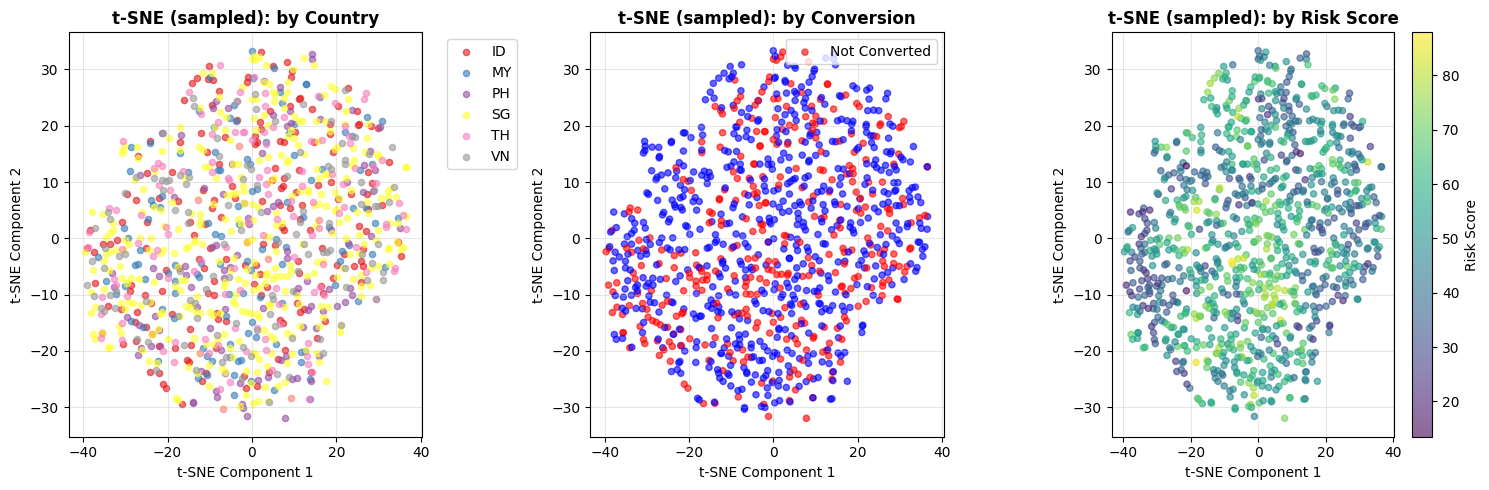

In [9]:
# t-SNE visualisation with stratified sampling and PCA(50)
print("\nApplying t-SNE on a stratified sample with PCA-50 pre-reduction...")

# Build stratified sample indices by country and converted_premium
N_MAX = 1000  # target maximum sample size; adjust as needed
frac = min(1.0, N_MAX / len(coinpilot_data))

# Ensure at least 1 row per stratum while keeping global proportion
sample_df = (coinpilot_data
             .groupby(['country', 'converted_premium'], group_keys=False)
             .apply(lambda x: x.sample(max(1, int(len(x) * frac)), random_state=42)))

print(f"Full size: {len(coinpilot_data):,}; Sample size: {len(sample_df):,}")

sample_idx = sample_df.index.values
# Rebuild scaled features directly from the sampled dataframe so plots are based on this df
X_cont_sample = sample_df[cont_cols]
X_bin_sample = sample_df[bin_cols]
scaler_vis = StandardScaler()
X_cont_sample_scaled = scaler_vis.fit_transform(X_cont_sample)
X_scaled_sample = np.hstack([X_cont_sample_scaled, X_bin_sample.values])

# Run t-SNE directly on scaled sample (no PCA pre-reduction)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled_sample)

# Create t-SNE visualization (use the sampled dataframe)
plt.figure(figsize=(15, 5))

# Plot 1: t-SNE colored by country
plt.subplot(1, 3, 1)
countries = sample_df['country'].unique()
colors = plt.cm.Set1(np.linspace(0, 1, len(countries)))
for i, country in enumerate(countries):
    mask = (sample_df['country'].values == country)
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=[colors[i]], label=country, alpha=0.6, s=20)
plt.title('t-SNE (sampled): by Country', fontsize=12, fontweight='bold')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Plot 2: t-SNE colored by conversion status
plt.subplot(1, 3, 2)
conv_vals = sample_df['converted_premium'].values
conversion_colors = np.where(conv_vals == 1, 'blue', 'red')
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=conversion_colors, alpha=0.6, s=20)
plt.title('t-SNE (sampled): by Conversion', fontsize=12, fontweight='bold')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(['Not Converted', 'Converted'], loc='upper right')
plt.grid(True, alpha=0.3)

# Plot 3: t-SNE colored by risk score (continuous)
plt.subplot(1, 3, 3)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=sample_df['risk_score'].values, 
                     cmap='viridis', alpha=0.6, s=20)
plt.colorbar(scatter, label='Risk Score')
plt.title('t-SNE (sampled): by Risk Score', fontsize=12, fontweight='bold')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


***2.3k-means clustering***

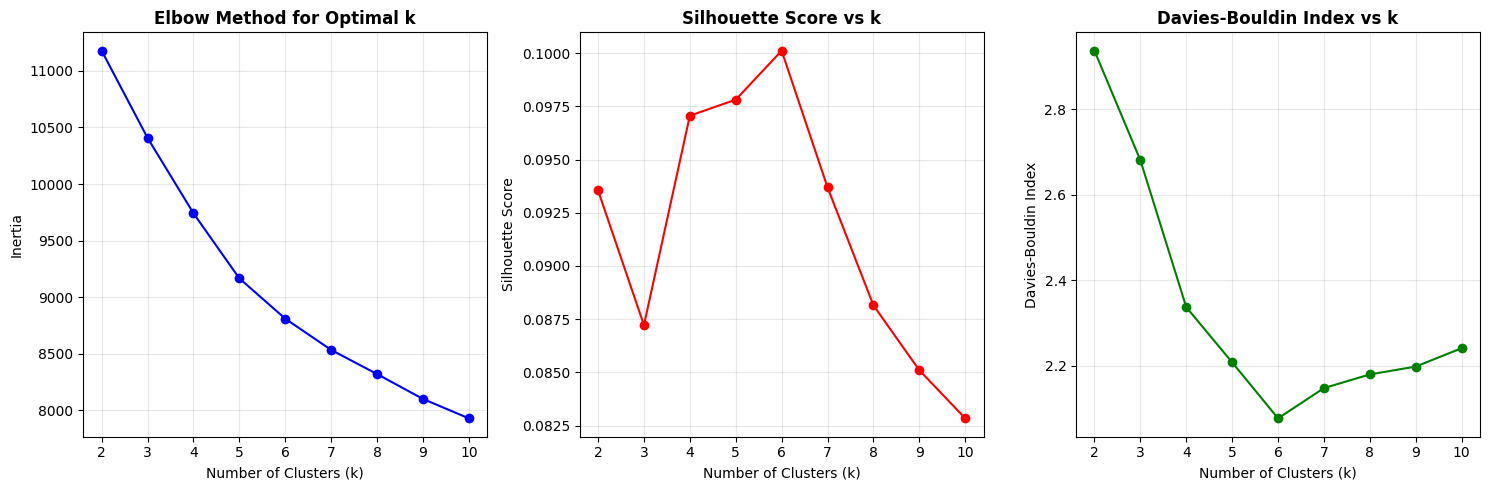

In [13]:
# K-means clustering and cluster profiling

# Test different numbers of clusters
k_range = range(2, 11)
inertias, silhouette_scores, davies_bouldin_scores = [], [], []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels_sample = kmeans.fit_predict(X_scaled_sample)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled_sample, cluster_labels_sample))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled_sample, cluster_labels_sample))

# Plot clustering evaluation metrics
plt.figure(figsize=(15, 5))

# Elbow method
plt.subplot(1, 3, 1)
plt.plot(k_range, inertias, 'bo-')
plt.title('Elbow Method for Optimal k', fontsize=12, fontweight='bold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True, alpha=0.3)

# Silhouette score
plt.subplot(1, 3, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.title('Silhouette Score vs k', fontsize=12, fontweight='bold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True, alpha=0.3)

# Davies-Bouldin index
plt.subplot(1, 3, 3)
plt.plot(k_range, davies_bouldin_scores, 'go-')
plt.title('Davies-Bouldin Index vs k', fontsize=12, fontweight='bold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Commentary
Write your observations here.




## 3) Ensemble modelling for premium conversion

### Your tasks in this section:
- Train and evaluate all three ensemble models (Random Forest, AdaBoost, XGBoost).
- Compare performance across accuracy, precision, recall, and ROC AUC.
- Include at least one feature importance visualisation.
- Add brief markdown comments on which features stand out as strong predictors.


In [ ]:
# Train-test split


# Random Forest with OOB


# AdaBoost with shallow base learner


# XGBoost classifier


# Compare metrics across models


# Feature importance visualisation(s)



### Commentary
Summarise standout features here.




## 4) Stacking and model comparison

### Your tasks in this section:
- Implement a StackingClassifier with two base models.
- Generate a results table showing all models with the same set of metrics.
- Create a comparison visualisation.
- Justify your chosen “best” model using your results.


In [ ]:
# StackingClassifier implementation


# Results table of all models


# Visual comparison (plot)




### Recommendation
Justify your chosen model here.




## 5) FastAPI prediction service and Streamlit client

### Your tasks in this section:
- Create and save the scikit-learn pipeline.
- Write and test the FastAPI endpoints.
- Develop a Streamlit client with online (API) and offline (local) prediction paths.
- Demonstrate at least one working prediction end-to-end.


In [ ]:
# Build pipeline (scaling + encoding + classifier) and save with joblib


# FastAPI app (define endpoints)


# Example code to run uvicorn server from notebook (optional)


# Streamlit client (API call + offline fallback)




## 6) Findings and recommendations

### Your tasks in this section:
- Summarise in 6–10 bullet points what your analysis uncovered:
  - Key user segments from clustering
  - Best-performing model for conversion prediction
  - Business-relevant features influencing premium conversion
  - Clear next steps for CoinPilot’s product and marketing team
- Keep findings grounded in your outputs (no speculation).


### Findings and Recommendations
- Point 1 …  
- Point 2 …  
- Point 3 …  
...




---

## Submission Guidelines

* **Due Date:** 28 Sep 2025 (Sunday), 11:59pm
* **Submission Method:** Upload single Jupyter notebook file
* **File Naming:** `name_assignment2.ipynb`
* **File Size:** Ensure notebook runs completely and all outputs are saved
* **Dependencies:** Include installation commands for all required packages in your notebook
* **Late Policy:** 10% deduction for every 24 hours late. No submission allowed beyond 48 hours late.

---
